In [2]:
import numpy as np
from numba import njit, prange

Ar pavyks optimizuoti bitų pakavimo algoritmą?

Vienas iš šio algoritmo pritaikymo pavyzdžių - [analogo vertimas į skaitmeną](https://www.youtube.com/watch?v=Ng00Mj5Tt8o&t=40s)

Tolimesnė diskusija apie šio algoritmo optimizavimo galimybių ribas - [StackOverflow](https://stackoverflow.com/questions/70712915/how-do-i-optimise-numpy-packbits-with-numba)

### Input

`X = np.random.randint(2, size=30, dtype=bool)`

arba

In [83]:
X = np.array([ True, False,  True,  True, False,  True,  True,  True, 
              False, False,  True, False, False,  True,  True,  True, 
              False,  True, False, False, False, False,  True, False,  
              True,  True,  True, False,  True, False])

### Output

In [84]:
np.packbits(X)

array([183,  39,  66, 232], dtype=uint8)

## Sprendimai
**Sprendimas 1**

In [4]:
@njit(parallel=True)
def _numba_dot(arr, div, su):
    for i in prange(div):
        k = i*8
        su[i] = arr[k]*128+arr[k+1]*64+arr[k+2]*32+arr[k+3]*16+arr[k+4]*8+arr[k+5]*4+arr[k+6]*2+arr[k+7]
        
def numba_dotbits(arr):
    'arr: dtype np.uint8, flat'
    div, mod = np.divmod(arr.size, 8)
    su = np.zeros(div + (mod>0), dtype=np.uint8)
    _numba_dot(arr[:div*8], div, su)
    if mod > 0:
        su[-1] = sum(x*y for x,y in zip(arr[div*8:], (128, 64, 32, 16, 8, 4, 2, 1)))
    return su

numba_dotbits(np.random.randint(2, size=200, dtype=bool))

array([135,  26, 125, 247, 194, 227, 134,  29, 205,  96, 223, 155,  66,
       216,  74, 250,  57, 132, 151, 210,  63, 203, 174,  42, 139],
      dtype=uint8)

**Sprendimas 2**

In [9]:
import numpy as np
from numba import njit, prange

@njit(parallel=True)
def _numba_pack(arr, div, su):
    for i in prange(div):
        s = 0
        for j in range(i*8, i*8+8):
            s = 2*s + arr[j]
        su[i] = s
        
def numba_packbits(arr):
    'arr: dtype np.uint8, flat'
    div, mod = np.divmod(arr.size, 8)
    su = np.zeros(div + (mod>0), dtype=np.uint8)
    _numba_pack(arr[:div*8], div, su)
    if mod > 0:
        su[-1] = sum(x*y for x,y in zip(arr[div*8:], (128, 64, 32, 16, 8, 4, 2, 1)))
    return su

X = np.random.randint(2, size=200, dtype=bool)
numba_packbits(X)

array([175, 215, 240,  66, 196, 237,  31, 192, 215,  65, 223, 201, 121,
        30, 197,  56, 101, 234, 157, 140,  58, 110, 232,  76,  35],
      dtype=uint8)

**Sprendimas 3**

In [6]:
import numpy as np
from numba import njit, prange

@njit(parallel=True)
def _numba_shift(arr, div, su):
    for i in prange(div):
        s = 0
        for j in range(i*8, i*8+8):
            s = (s<<1) | arr[j]
        su[i] = s
        
def numba_shiftbits(arr):
    'arr: dtype np.uint8, flat'
    div, mod = np.divmod(arr.size, 8)
    su = np.zeros(div + (mod>0), dtype=np.uint8)
    _numba_shift(arr[:div*8], div, su)
    if mod > 0:
        su[-1] = sum(x*y for x,y in zip(arr[div*8:], (128, 64, 32, 16, 8, 4, 2, 1)))
    return su

X = np.random.randint(2, size=99, dtype=bool)
print(numba_shiftbits(X))

[  9   5 239 121  23  84 243 142 133 247  93  41   0]


### Run with the beginners

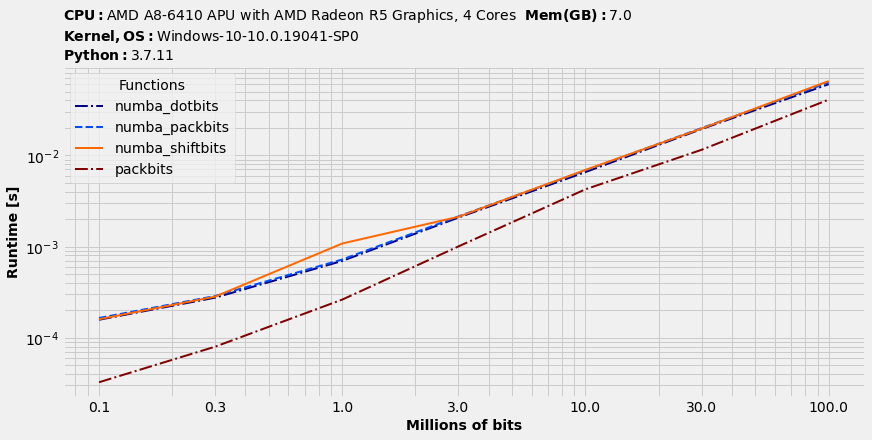

In [7]:
import benchit
from numpy import packbits
%matplotlib inline
benchit.setparams(rep=3)

sizes = [100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000]
N = sizes[-1]
arr = np.random.randint(2, size=N, dtype=bool)
fns = [numba_dotbits, numba_packbits, numba_shiftbits, packbits]

in_ = {s/1000000: (arr[:s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Millions of bits')
t.plot(logx=True, figsize=(12, 6), fontsize=14)

## Run with the expert

In [19]:
@njit('void(bool_[::1], uint8[::1], int_)', inline='never')
def _numba_pack_x64_byJérôme(arr, su, pos):
    for i in range(64):
        j = i * 8
        su[i] = (arr[j]<<7)|(arr[j+1]<<6)|(arr[j+2]<<5)|(arr[j+3]<<4)|(arr[j+4]<<3)|(arr[j+5]<<2)|(arr[j+6]<<1)|arr[j+7]
       
@njit(parallel=True)
def _numba_pack_byJérôme(arr, div, su):
    for i in prange(div//64):
        _numba_pack_x64_byJérôme(arr[i*8:(i+64)*8], su[i:i+64], i)
    for i in range(div//64*64, div):
        j = i * 8
        su[i] = (arr[j]<<7)|(arr[j+1]<<6)|(arr[j+2]<<5)|(arr[j+3]<<4)|(arr[j+4]<<3)|(arr[j+5]<<2)|(arr[j+6]<<1)|arr[j+7]
        
def numba_packbits_byJérôme(arr):
    div, mod = np.divmod(arr.size, 8)
    su = np.zeros(div + (mod>0), dtype=np.uint8)
    _numba_pack_byJérôme(arr[:div*8], div, su)
    if mod > 0:
        su[-1] = sum(x*y for x,y in zip(arr[div*8:], (128, 64, 32, 16, 8, 4, 2, 1)))
    return su

X = np.random.randint(2, size=99, dtype=bool)
print(numba_packbits(X))
print(numba_packbits_byJérôme(X))

[ 75  24  79  61 209 189 203 187  47 226 170  61   0]
[ 75  24  79  61 209 189 203 187  47 226 170  61   0]


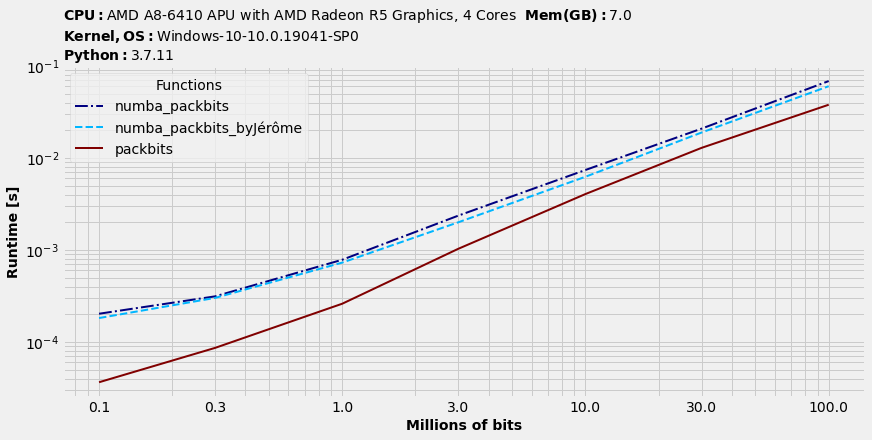

In [20]:
import benchit
from numpy import packbits
%matplotlib inline
benchit.setparams(rep=5)

sizes = [100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000]
N = sizes[-1]
arr = np.random.randint(2, size=N, dtype=bool)
fns = [numba_packbits, numba_packbits_byJérôme, packbits]

in_ = {s/1000000: (arr[:s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Millions of bits')
t.plot(logx=True, figsize=(12, 6), fontsize=14)

### Notes
Panašu, kad bitų pakavimo optimizavimas su `numba` negali pasivyti `numpy`, nes `numpy.packbits` naudoja [SIMD](https://en.wikipedia.org/wiki/SIMD). Tačiau kitų vartotojų atsiliepimai sako ką kita:

    On a Xeon Skylake-SP machine with 10 cores (and 20 threads), Numpy 1.20.3 and Numba 0.54.1, it turns out that your Numba implementation is 14 times faster than np.packbits on a 1G-sized array. It is also 2 times faster in sequential. So, the question is why it is slower on some platforms (including yours). It turns out that the Numpy implementation is not so well optimized (at least the default package)...